# Wing Analysis - XFLR5 Data

This notebook reads and analyzes XFLR5 wing analysis data from the `wing_analysis` directory.

**Workflow:**
1. Import required libraries
2. Load all XFLR5 analysis files
3. Parse aerodynamic coefficients (Cl, Cd, alpha)
4. Create comparison plots
5. Calculate lift-to-drag ratios


## 1. Import Required Libraries


In [38]:
import os
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


## 2. Set Up File Paths and Discover Analysis Files


In [39]:
# Configuration
data_dir = Path('../data/airfoil_analysis')
output_dir = Path('./data')
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {data_dir}")
print(f"Output directory: {output_dir}")

# Find all analysis files (now CSV files)
analysis_files = sorted(list(data_dir.glob('wing_data_*.csv')))

print(f"\n✓ Found {len(analysis_files)} analysis files:")
for file in analysis_files:
    print(f"  - {file.name}")

Data directory: ../data/airfoil_analysis
Output directory: data

✓ Found 6 analysis files:
  - wing_data_AG25_Re0.100.csv
  - wing_data_AG25_Re0.200.csv
  - wing_data_AG25_Re0.500.csv
  - wing_data_NACA0015_Re0.100.csv
  - wing_data_NACA0015_Re0.200.csv
  - wing_data_NACA0015_Re0.500.csv


## 3. Inspect File Structure

Let's look at the first file to understand the data format.


In [40]:
# Read and display first few rows of the first file
if len(analysis_files) > 0:
    print(f"Inspecting: {analysis_files[0].name}\n")
    print("=" * 80)
    
    df_sample = pd.read_csv(analysis_files[0])
    print(f"Shape: {df_sample.shape}")
    print(f"\nColumns: {list(df_sample.columns)}")
    print(f"\nFirst 10 rows:")
    print(df_sample.head(10))
    
    print("=" * 80)
else:
    print("⚠ No analysis files found!")

Inspecting: wing_data_AG25_Re0.100.csv

Shape: (69, 15)

Columns: ['alpha', 'CL', 'CD', 'CDp', 'Cm', 'Top', 'Xtr', 'Bot', 'Xtr.1', 'Cpmin', 'Chinge', 'XCp', 'airfoil', 'Reynolds', 'NCrit']

First 10 rows:
   alpha      CL       CD      CDp      Cm  Top     Xtr     Bot  Xtr.1  Cpmin  \
0  -33.0 -1.1942  0.40107  0.39630  0.2035  1.0  0.0088 -2.0472    0.0    0.0   
1  -32.0 -1.1723  0.39125  0.38638  0.1932  1.0  0.0092 -1.9558    0.0    0.0   
2  -31.0 -1.1480  0.38208  0.37715  0.1826  1.0  0.0097 -1.8889    0.0    0.0   
3  -30.0 -1.1219  0.37261  0.36760  0.1721  1.0  0.0102 -1.8246    0.0    0.0   
4  -29.0 -1.0942  0.36274  0.35766  0.1616  1.0  0.0109 -1.7585    0.0    0.0   
5  -28.0 -1.0651  0.35250  0.34736  0.1512  1.0  0.0118 -1.7357    0.0    0.0   
6  -27.0 -1.0336  0.34227  0.33705  0.1407  1.0  0.0131 -1.7861    0.0    0.0   
7  -26.0 -1.0012  0.33328  0.32803  0.1296  1.0  0.0135 -1.8668    0.0    0.0   
8  -25.0 -0.9693  0.32509  0.31980  0.1184  1.0  0.0137 -1.9323   

## 4. Load and Parse All Analysis Files

Based on the file structure, we'll create a parser to extract the aerodynamic data.


In [41]:
def parse_csv_file(file_path):
    """
    Parse CSV wing data file.
    
    Returns:
        dict: Contains metadata and pandas DataFrame with aero data
    """
    # Read CSV file
    df = pd.read_csv(file_path)
    
    # Extract metadata from first row
    metadata = {
        'filename': file_path.name,
        'airfoil': df['airfoil'].iloc[0] if 'airfoil' in df.columns else 'Unknown',
        'Reynolds': df['Reynolds'].iloc[0] if 'Reynolds' in df.columns else 0.0,
        'NCrit': df['NCrit'].iloc[0] if 'NCrit' in df.columns else 5.0,
        'data': df
    }
    
    return metadata


# Load all files
print("Loading wing analysis CSV files...\n")
analysis_data = []

for file_path in analysis_files:
    result = parse_csv_file(file_path)
    if result and 'data' in result:
        analysis_data.append(result)
        print(f"✓ Loaded {file_path.name}: {len(result['data'])} data points")
        print(f"  Airfoil: {result['airfoil']}, Re: {result['Reynolds']:.3f}, NCrit: {result['NCrit']}")
    else:
        print(f"⚠ Could not parse {file_path.name}")

print(f"\n✓ Successfully loaded {len(analysis_data)} files")

Loading wing analysis CSV files...

✓ Loaded wing_data_AG25_Re0.100.csv: 69 data points
  Airfoil: AG25, Re: 0.100, NCrit: 5.0
✓ Loaded wing_data_AG25_Re0.200.csv: 38 data points
  Airfoil: AG25, Re: 0.200, NCrit: 5.0
✓ Loaded wing_data_AG25_Re0.500.csv: 54 data points
  Airfoil: AG25, Re: 0.500, NCrit: 5.0
✓ Loaded wing_data_NACA0015_Re0.100.csv: 54 data points
  Airfoil: NACA0015, Re: 0.100, NCrit: 5.0
✓ Loaded wing_data_NACA0015_Re0.200.csv: 40 data points
  Airfoil: NACA0015, Re: 0.200, NCrit: 5.0
✓ Loaded wing_data_NACA0015_Re0.500.csv: 47 data points
  Airfoil: NACA0015, Re: 0.500, NCrit: 5.0

✓ Successfully loaded 6 files


## 5. Display Sample Data

Let's examine the first loaded dataset.


In [42]:
if len(analysis_data) > 0:
    sample = analysis_data[0]
    
    print("=" * 80)
    print(f"Sample Dataset: {sample['filename']}")
    print("=" * 80)
    print(f"Airfoil: {sample['airfoil']}")
    print(f"Reynolds Number: {sample['Reynolds']}")
    print(f"Mach Number: {sample['Mach']}")
    print(f"NCrit: {sample['NCrit']}")
    print(f"\nData shape: {sample['data'].shape}")
    print(f"\nColumns: {list(sample['data'].columns)}")
    print(f"\nFirst few rows:")
    display(sample['data'].head(10))
    print(f"\nSummary statistics:")
    display(sample['data'].describe())
else:
    print("⚠ No data loaded!")


Sample Dataset: wing_data_AG25_Re0.100.csv
Airfoil: AG25
Reynolds Number: 0.1


KeyError: 'Mach'

## 6. Plot Aerodynamic Coefficients

Create plots comparing different analyses.


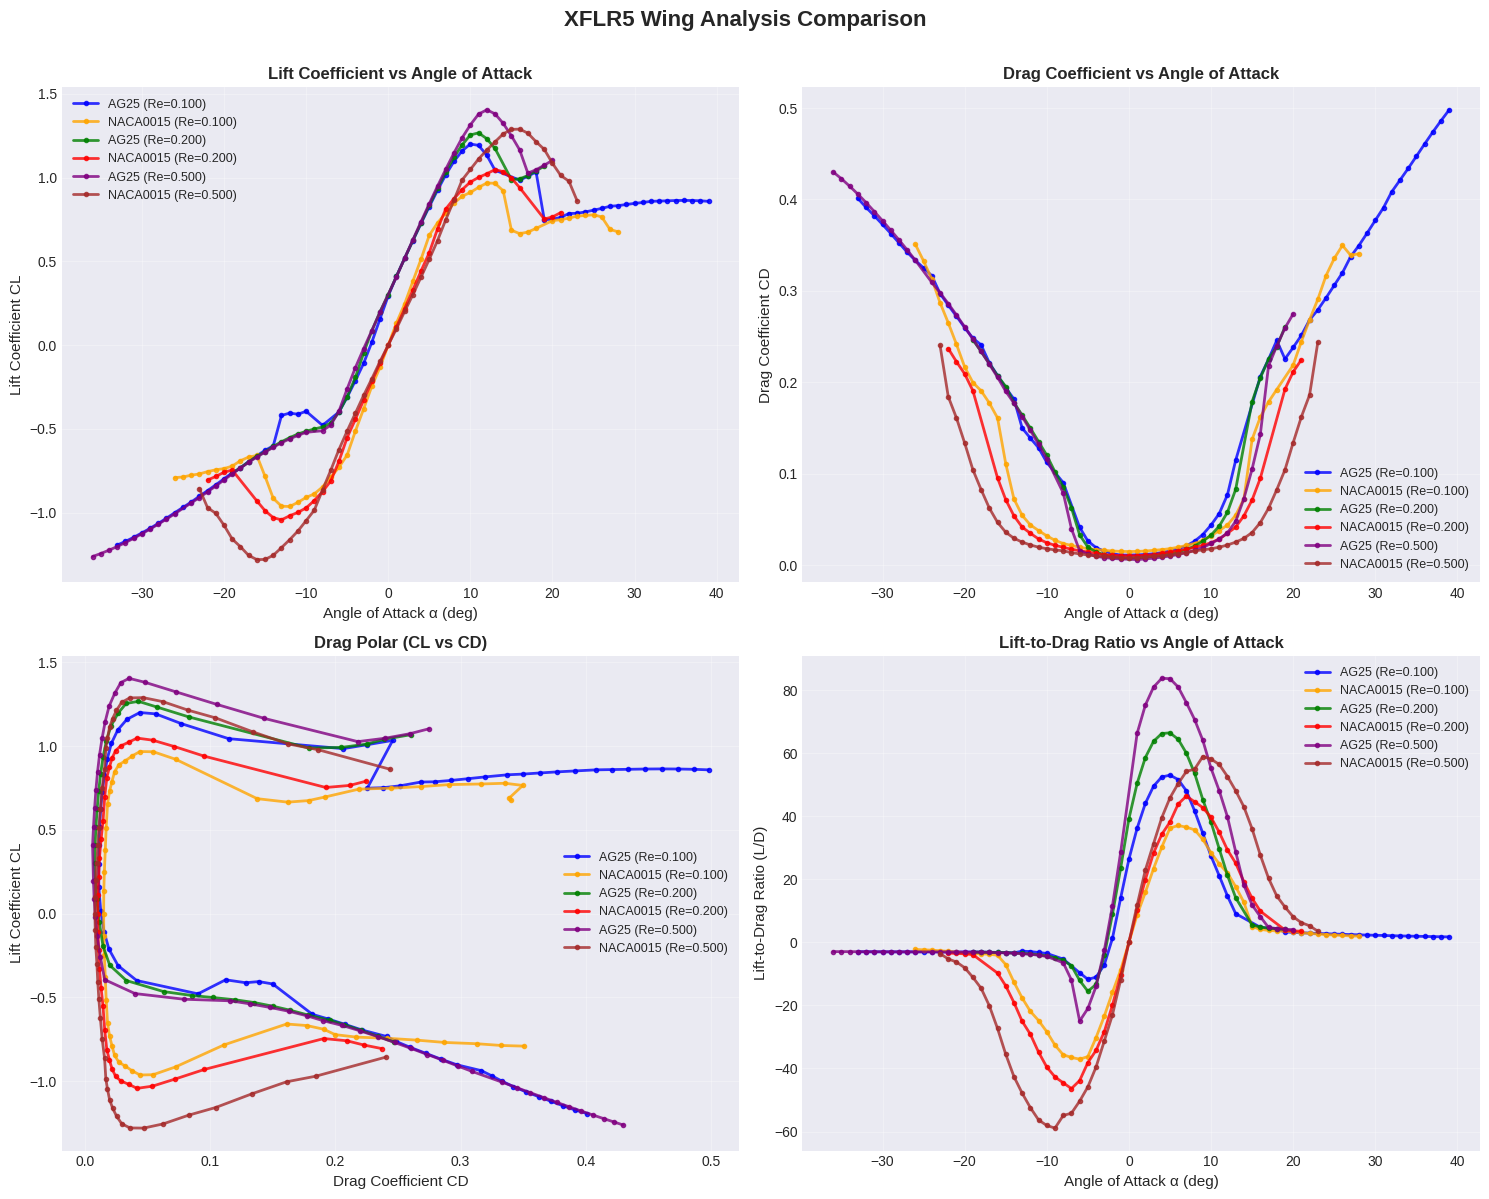

✓ Saved: wing_analysis_comparison.png


In [ ]:
if len(analysis_data) > 0:
    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('XFLR5 Wing Analysis Comparison', fontsize=16, fontweight='bold', y=0.995)
    
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
    
    for idx, data in enumerate(analysis_data):
        df = data['data']
        label = f"{data['airfoil']} (Re={data['Reynolds']:.3f})"
        color = colors[idx % len(colors)]
        
        # CL vs alpha
        if 'alpha' in df.columns and 'CL' in df.columns:
            axes[0, 0].plot(df['alpha'], df['CL'], marker='o', markersize=3, 
                           linewidth=2, alpha=0.8, color=color, label=label)
        
        # CD vs alpha  
        if 'alpha' in df.columns and 'CD' in df.columns:
            axes[0, 1].plot(df['alpha'], df['CD'], marker='o', markersize=3,
                           linewidth=2, alpha=0.8, color=color, label=label)
        
        # CL vs CD (drag polar)
        if 'CL' in df.columns and 'CD' in df.columns:
            axes[1, 0].plot(df['CD'], df['CL'], marker='o', markersize=3,
                           linewidth=2, alpha=0.8, color=color, label=label)
        
        # L/D vs alpha
        if 'CL' in df.columns and 'CD' in df.columns and 'alpha' in df.columns:
            LD_ratio = df['CL'] / df['CD']
            axes[1, 1].plot(df['alpha'], LD_ratio, marker='o', markersize=3,
                           linewidth=2, alpha=0.8, color=color, label=label)
    
    # Configure subplots
    axes[0, 0].set_xlabel('Angle of Attack α (deg)', fontsize=11)
    axes[0, 0].set_ylabel('Lift Coefficient CL', fontsize=11)
    axes[0, 0].set_title('Lift Coefficient vs Angle of Attack', fontsize=12, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend(fontsize=9)
    
    axes[0, 1].set_xlabel('Angle of Attack α (deg)', fontsize=11)
    axes[0, 1].set_ylabel('Drag Coefficient CD', fontsize=11)
    axes[0, 1].set_title('Drag Coefficient vs Angle of Attack', fontsize=12, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend(fontsize=9)
    
    axes[1, 0].set_xlabel('Drag Coefficient CD', fontsize=11)
    axes[1, 0].set_ylabel('Lift Coefficient CL', fontsize=11)
    axes[1, 0].set_title('Drag Polar (CL vs CD)', fontsize=12, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend(fontsize=9)
    
    axes[1, 1].set_xlabel('Angle of Attack α (deg)', fontsize=11)
    axes[1, 1].set_ylabel('Lift-to-Drag Ratio (L/D)', fontsize=11)
    axes[1, 1].set_title('Lift-to-Drag Ratio vs Angle of Attack', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend(fontsize=9)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig(output_dir / 'wing_analysis_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Saved: wing_analysis_comparison.png")
else:
    print("⚠ No data to plot!")


## 6b. Export Data to CSV for LaTeX Plotting

Export the aerodynamic coefficients to CSV files for use in LaTeX with pgfplots or similar.

In [ ]:
if len(analysis_data) > 0:
    print("Exporting data to CSV files...\n")
    
    # Create a combined CSV with all data
    all_data_rows = []
    
    for data in analysis_data:
        df = data['data']
        
        # Add metadata columns
        df_export = df.copy()
        df_export['airfoil'] = data['airfoil']
        df_export['Reynolds'] = data['Reynolds']
        df_export['NCrit'] = data['NCrit']
        
        all_data_rows.append(df_export)
        
        # Also save individual files for each configuration
        sanitized_name = data['airfoil'].replace(' ', '_').replace('/', '_')
        filename = f"wing_data_{sanitized_name}_Re{data['Reynolds']:.3f}.csv"
        df_export.to_csv(output_dir / filename, index=False)
        print(f"✓ Saved: {filename}")
    
    # Combine all data into one file
    combined_df = pd.concat(all_data_rows, ignore_index=True)
    combined_df.to_csv(output_dir / 'wing_analysis_combined.csv', index=False)
    print(f"\n✓ Saved: wing_analysis_combined.csv (all configurations)")
    
    # Create separate files for each plot type (easier for LaTeX)
    print("\nCreating plot-specific CSV files...")
    
    for idx, data in enumerate(analysis_data):
        df = data['data']
        sanitized_name = data['airfoil'].replace(' ', '_').replace('/', '_')
        prefix = f"{sanitized_name}_Re{data['Reynolds']:.3f}"
        
        # CL vs alpha
        if 'alpha' in df.columns and 'CL' in df.columns:
            cl_data = df[['alpha', 'CL']].copy()
            cl_data.columns = ['alpha', 'CL']
            cl_data.to_csv(output_dir / f'CL_vs_alpha_{prefix}.csv', index=False)
        
        # CD vs alpha
        if 'alpha' in df.columns and 'CD' in df.columns:
            cd_data = df[['alpha', 'CD']].copy()
            cd_data.columns = ['alpha', 'CD']
            cd_data.to_csv(output_dir / f'CD_vs_alpha_{prefix}.csv', index=False)
        
        # Drag polar (CL vs CD)
        if 'CL' in df.columns and 'CD' in df.columns:
            polar_data = df[['CD', 'CL']].copy()
            polar_data.columns = ['CD', 'CL']
            polar_data.to_csv(output_dir / f'drag_polar_{prefix}.csv', index=False)
        
        # L/D vs alpha
        if 'CL' in df.columns and 'CD' in df.columns and 'alpha' in df.columns:
            LD_ratio = df['CL'] / df['CD']
            ld_data = pd.DataFrame({
                'alpha': df['alpha'],
                'LD': LD_ratio
            })
            ld_data.to_csv(output_dir / f'LD_vs_alpha_{prefix}.csv', index=False)
    
    print(f"\n✓ Exported plot-specific CSV files for {len(analysis_data)} configurations")
    print(f"\nAll files saved to: {output_dir}")
    print("\nFile naming convention:")
    print("  - wing_analysis_combined.csv: All data combined")
    print("  - wing_data_[airfoil]_Re[Reynolds].csv: Individual configuration data")
    print("  - CL_vs_alpha_[airfoil]_Re[Reynolds].csv: Lift coefficient data")
    print("  - CD_vs_alpha_[airfoil]_Re[Reynolds].csv: Drag coefficient data")
    print("  - drag_polar_[airfoil]_Re[Reynolds].csv: Drag polar data")
    print("  - LD_vs_alpha_[airfoil]_Re[Reynolds].csv: Lift-to-drag ratio data")
else:
    print("⚠ No data to export!")

Exporting data to CSV files...

✓ Saved: wing_data_AG25_Re0.100.csv
✓ Saved: wing_data_NACA0015_Re0.100.csv
✓ Saved: wing_data_AG25_Re0.200.csv
✓ Saved: wing_data_NACA0015_Re0.200.csv
✓ Saved: wing_data_AG25_Re0.500.csv
✓ Saved: wing_data_NACA0015_Re0.500.csv

✓ Saved: wing_analysis_combined.csv (all configurations)

Creating plot-specific CSV files...

✓ Exported plot-specific CSV files for 6 configurations

All files saved to: data

File naming convention:
  - wing_analysis_combined.csv: All data combined
  - wing_data_[airfoil]_Re[Reynolds].csv: Individual configuration data
  - CL_vs_alpha_[airfoil]_Re[Reynolds].csv: Lift coefficient data
  - CD_vs_alpha_[airfoil]_Re[Reynolds].csv: Drag coefficient data
  - drag_polar_[airfoil]_Re[Reynolds].csv: Drag polar data
  - LD_vs_alpha_[airfoil]_Re[Reynolds].csv: Lift-to-drag ratio data


## 7. Calculate Key Performance Metrics

Extract important aerodynamic characteristics.


In [ ]:
if len(analysis_data) > 0:
    print("=" * 80)
    print("KEY AERODYNAMIC PERFORMANCE METRICS")
    print("=" * 80)
    
    for data in analysis_data:
        df = data['data']
        
        print(f"\n{data['airfoil']} (Re={data['Reynolds']:.3f}, NCrit={data['NCrit']}):")
        print("-" * 80)
        
        if 'CL' in df.columns and 'CD' in df.columns and 'alpha' in df.columns:
            # Maximum L/D
            LD_ratio = df['CL'] / df['CD']
            max_LD_idx = LD_ratio.idxmax()
            max_LD = LD_ratio[max_LD_idx]
            alpha_max_LD = df.loc[max_LD_idx, 'alpha']
            CL_max_LD = df.loc[max_LD_idx, 'CL']
            CD_max_LD = df.loc[max_LD_idx, 'CD']
            
            print(f"  Maximum L/D:        {max_LD:.2f} at α = {alpha_max_LD:.2f}°")
            print(f"    CL at max L/D:    {CL_max_LD:.4f}")
            print(f"    CD at max L/D:    {CD_max_LD:.4f}")
            
            # Maximum CL
            max_CL_idx = df['CL'].idxmax()
            max_CL = df.loc[max_CL_idx, 'CL']
            alpha_max_CL = df.loc[max_CL_idx, 'alpha']
            
            print(f"  Maximum CL:         {max_CL:.4f} at α = {alpha_max_CL:.2f}°")
            
            # Minimum CD
            min_CD_idx = df['CD'].idxmin()
            min_CD = df.loc[min_CD_idx, 'CD']
            alpha_min_CD = df.loc[min_CD_idx, 'alpha']
            
            print(f"  Minimum CD:         {min_CD:.4f} at α = {alpha_min_CD:.2f}°")
            
            # Zero-lift angle
            zero_lift_idx = (df['CL'].abs()).idxmin()
            alpha_zero_lift = df.loc[zero_lift_idx, 'alpha']
            
            print(f"  Zero-lift angle:    α₀ ≈ {alpha_zero_lift:.2f}°")
            
            # CL and CD at typical cruise angles
            for cruise_alpha in [0, 2, 4, 6]:
                idx = (df['alpha'] - cruise_alpha).abs().idxmin()
                if abs(df.loc[idx, 'alpha'] - cruise_alpha) < 1.0:  # Within 1 degree
                    CL_cruise = df.loc[idx, 'CL']
                    CD_cruise = df.loc[idx, 'CD']
                    LD_cruise = CL_cruise / CD_cruise
                    print(f"  At α = {cruise_alpha}°:         CL = {CL_cruise:.4f}, CD = {CD_cruise:.4f}, L/D = {LD_cruise:.2f}")
        
        print()
    
    print("=" * 80)
else:
    print("⚠ No data available for metrics calculation!")


KEY AERODYNAMIC PERFORMANCE METRICS

AG25 (Re=0.100, NCrit=5.0):
--------------------------------------------------------------------------------
  Maximum L/D:        53.02 at α = 5.00°
    CL at max L/D:    0.8271
    CD at max L/D:    0.0156
  Maximum CL:         1.2007 at α = 10.00°
  Minimum CD:         0.0111 at α = -1.00°
  Zero-lift angle:    α₀ ≈ -2.00°
  At α = 0°:         CL = 0.2943, CD = 0.0112, L/D = 26.37
  At α = 2°:         CL = 0.5186, CD = 0.0118, L/D = 44.06
  At α = 4°:         CL = 0.7265, CD = 0.0138, L/D = 52.45
  At α = 6°:         CL = 0.9246, CD = 0.0179, L/D = 51.62


NACA0015 (Re=0.100, NCrit=5.0):
--------------------------------------------------------------------------------
  Maximum L/D:        37.06 at α = 6.00°
    CL at max L/D:    0.7294
    CD at max L/D:    0.0197
  Maximum CL:         0.9677 at α = 12.00°
  Minimum CD:         0.0150 at α = 0.00°
  Zero-lift angle:    α₀ ≈ 0.00°
  At α = 0°:         CL = 0.0000, CD = 0.0150, L/D = 0.00
  At α = 

## 8. Analysis Complete


In [ ]:
print("=" * 80)
print("WING ANALYSIS SUMMARY")
print("=" * 80)
print(f"\nAnalyzed {len(analysis_data)} XFLR5 datasets")
print(f"\nOutput directory: {output_dir}")
print(f"\n📊 Generated plots:")
print(f"  - wing_analysis_comparison.png")
print("\n" + "=" * 80)


WING ANALYSIS SUMMARY

Analyzed 6 XFLR5 datasets

Output directory: data

📊 Generated plots:
  - wing_analysis_comparison.png

